In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mineralML as mm
import Thermobar as pt


In [17]:
#mm.__version__

In [18]:
def process_excel_file(file_path, sheet_name=1):
    # Load the Excel file from the specified sheet without headers
    data = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    
    # Find indices where 'Element' is found in column 0 to determine the start of data blocks
    data_blocks_indices = data.index[data[0] == 'Element'].tolist()
    
    # Initialize an empty DataFrame to store processed data
    processed_data = []

    # Iterate through each data block
    for i, start in enumerate(data_blocks_indices):
        print(f"Processing row: {start + 1}")
        # The label for the block is in the row just before the 'Element' row
        label = data.iloc[start - 1, 0]
        
        # Identify the end of the block by finding the next 'Total' row after 'Element'
        total_index = data.index[(data[0] == 'Total') & (data.index > start)].min()
        end = total_index  # Set end to the row before 'Total
        
        # Extract data block for current sample
        block = data.iloc[start + 1:end]  # Extract rows between 'Element' and 'Total'
        headers = ['Element'] + data.iloc[start, 1:].dropna().values.tolist()  # Get headers from the 'Element' row
        
        # Ensure the number of columns matches expected headers
        block.columns = headers[:block.shape[1]]
        
        # Prepare a row dictionary to append to the DataFrame
        row_dict = {'Sample Name': label}
        for _, row in block.iterrows():
            element = row['Element']
            
            for col in row.index[1:]:  # Skip the 'Element' column for key names
                if pd.notna(row[col]):  # Check for NaN
                    col_name = f"{col}_{element}"  # Use header from 'Element' row for column names
                    row_dict[col_name] = row[col]

        # Capture 'Total_wt%' and 'Total_Oxide %' from the 'Total' row
        total_row = data.iloc[total_index, :]  # Correctly access the 'Total' row
        row_dict['Total_wt%'] = total_row.get(headers.index('Wt%'), None)  # Use dynamic index for 'Wt%'
        row_dict['Total_Oxide%'] = total_row.get(headers.index('Oxide %'), None)  # Use dynamic index for 'Oxide %'
        # row_dict['Cation_Sum'] = total_row.get(headers.index('Number of Ions'), None)  # Use dynamic index for 'Oxide %'
        # row_dict['Cation_Sum']=row_dict['Cation_Sum'].replace('(Cation sum)', '')

                    
        processed_data.append(row_dict)

    return pd.DataFrame(processed_data)



In [19]:
def sort_columns(df, norm = False):
    # Start with fixed priority columns
    priority_cols = ['Sample Name', 'Total_wt%', 'Total_Oxide%'] #, 'Cation_Sum']

    # Define exact matches for metrics and their intended order
    col_order = ['Oxide %_', 'Oxide % Sigma_', 'norm_Oxide %_', 'Wt%_', 'Wt% Sigma_']


    element_to_oxide = {
        'Si': 'SiO2', 'Ti': 'TiO2', 'Al': 'Al2O3', 'Ca': 'CaO',
        'Cr': 'Cr2O3', 'Fe': 'FeO', 'Ni': 'NiO', 'Na': 'Na2O',
        'Mg': 'MgO','Mn': 'MnO',
        'K': 'K2O', 'P': 'P2O5'
    }

    # Rename columns based on the mapping
    new_columns = {}
    for col in df.columns:
        if 'Oxide' in col:
            for element, oxide in element_to_oxide.items():
                if f'_{element}' in col:
                    new_col_name = col.replace(f'_{element}', f'_{oxide}')
                    new_columns[col] = new_col_name

    df.rename(columns=new_columns, inplace=True)
    
    
    # Find the columns that are going to be involved in the normalization
    desired_string = 'Oxide %_'
    matching_columns = [col for col in df.columns if desired_string in col]
    matching_column_indices = [df.columns.get_loc(col) for col in matching_columns]
        
    # Convert SO3 to SO2
    if 'Oxide %_S' in list(df.keys()):
        df = df.rename(columns={'Oxide %_S': 'Oxide %_SO2'})
        df['Oxide %_SO2'] = df['Oxide %_SO2']*(32.065+2*15.999)/(32.065+3*15.999)

    # normalization
    df_norm = df.iloc[:, matching_column_indices]
    df_norm = df_norm.map(lambda x: 0 if x < 0 else x)
    sum = df_norm.sum(axis = 1)
    df_norm = 100*df_norm.div(sum, axis = 0)

    df_norm = df_norm.add_suffix('_norm')
    df_norm = df_norm.add_prefix('norm_')
    df_norm = df_norm.fillna(0.0)

    df = pd.concat([df, df_norm], axis=1)

    # if norm is true, switch normalized and un-normalized analyses
    if norm is True:
        elements = set([col.split('_')[-1].split('_norm')[0] for col in df.columns if 'Oxide %_' in col])
        
        # Swap the data between corresponding columns
        for element in elements:
            if element != 'norm':
                oxide_col = f'Oxide %_{element}'
                norm_oxide_col = f'norm_Oxide %_{element}_norm'
                
                # Swap the data using a temporary variable
                temp = df[oxide_col].copy()
                df[oxide_col] = df[norm_oxide_col]
                df[norm_oxide_col] = temp


    # Collect and sort metric-specific columns using more accurate matching
    metric_cols = []
    for metric in col_order:
        # This loop will check if the columns end with the metric name preceded by an underscore
        # to ensure we match 'Oxide %_Mg' but not 'Something Oxide %_Mg'
        metric_cols.extend(sorted([col for col in df.columns if col.startswith(metric)]))

    
    # Collect all other columns not in priority or metric-specific lists
    other_cols = [col for col in df.columns if col not in priority_cols and col not in metric_cols]

    # Move 'Apparent Concentration' columns to the end
    apparent_concentration_cols = [col for col in other_cols if 'Apparent Concentration' in col]
    other_cols = [col for col in other_cols if col not in apparent_concentration_cols]

    # Combine all columns in the desired order
    final_cols = priority_cols + metric_cols + sorted(other_cols) + sorted(apparent_concentration_cols)

    # Debugging: Print out final column order
    # Move 'Apparent Concentration' columns to the end
    for bad_names in ['Apparent Concentration', 'Factory Standard', 'Line', 'Number of Ions']:
        
        apparent_concentration_cols = [col for col in df.columns if bad_names in col]
        final_cols = [col for col in final_cols if col not in apparent_concentration_cols] + apparent_concentration_cols

    df_out=df[final_cols]

    # replace column headers to make compatible with MinML
    
    df_out.rename(columns=lambda x: x.replace('norm_Oxide %_', ''), inplace=True)   
    if norm is True:
        df_out.rename(columns=lambda x: x.replace('_norm','_unnorm'), inplace=True)
         
    df_out.rename(columns=lambda x: x.replace('Oxide %_', ''), inplace=True)
    df_out.rename(columns=lambda x: x.replace('Number of Ions', '#_ions_'), inplace=True)
    df_out.rename(columns=lambda x: x.replace('FeO', 'FeOt'), inplace=True)

    # Reorder DataFrame
    return df_out


## Scroll down to here to run!

In [20]:
# Had to delete beam current column - e.g. P in excel and onwards ,because it cant deal with changing column headings. 
result = process_excel_file('KL_060824_olivines.xlsx', sheet_name="Sheet1")
sorted_df = sort_columns(result)
sorted_df['SampleID']=sorted_df['Sample Name']
sorted_df['Fo']=(sorted_df['MgO']/40.3044)/((sorted_df['MgO']/40.3044)+(sorted_df['FeOt']/71.844))
sorted_df.to_csv('sorted_df.xlsx')

Processing row: 2
Processing row: 12
Processing row: 22
Processing row: 32
Processing row: 42
Processing row: 52
Processing row: 62
Processing row: 72
Processing row: 85
Processing row: 98
Processing row: 110
Processing row: 120
Processing row: 128
Processing row: 138
Processing row: 148
Processing row: 158
Processing row: 168
Processing row: 178
Processing row: 188
Processing row: 198
Processing row: 208
Processing row: 218
Processing row: 228
Processing row: 238
Processing row: 248
Processing row: 258
Processing row: 268
Processing row: 278
Processing row: 288
Processing row: 298
Processing row: 308
Processing row: 318
Processing row: 328
Processing row: 338
Processing row: 348
Processing row: 358
Processing row: 368
Processing row: 378
Processing row: 388
Processing row: 398
Processing row: 408
Processing row: 418
Processing row: 428
Processing row: 438
Processing row: 448
Processing row: 458
Processing row: 468
Processing row: 478
Processing row: 488
Processing row: 498
Processing 

## Now lets merge the SEM dataframe with the Raman data

In [21]:
Raman_df=pd.read_excel('Google KL_SWRZ_wdepths.xlsx')
Raman_df.head()

,Unnamed: 0,Mount,filename,Name_on_SEM,Notes regarding SEM matching,Unnamed: 5,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),...,T_K_input,error_T_K,CO2_dens_gcm3_input,error_CO2_dens_gcm3,crust_dens_kgm3_input,error_crust_dens_kgm3,model,EOS,XH2O_input,error_XH2O
0,0,NaN,FG04-A1-1-start,NaN,NaN,FG04_A1_1_start,0.609630,0.007472,0.007085,0.002372,...,1423.15,100,0.609630,0.007472,NaN,5,denlinger_lerner,DZ06,0.1,0.05
1,1,NaN,FG04-A1-16,NaN,NaN,FG04_A1_16,0.478732,0.004766,0.004145,0.002353,...,1423.15,100,0.478732,0.004766,NaN,5,denlinger_lerner,DZ06,0.1,0.05
2,2,NaN,FG04-A1-16,NaN,NaN,FG04_A1_16,0.480376,0.004752,0.004129,0.002353,...,1423.15,100,0.480376,0.004752,NaN,5,denlinger_lerner,DZ06,0.1,0.05
3,3,NaN,FG04-A1-16-start,NaN,NaN,FG04_A1_16_start,0.494153,0.004861,0.004253,0.002355,...,1423.15,100,0.494153,0.004861,NaN,5,denlinger_lerner,DZ06,0.1,0.05
4,4,NaN,FG04-A1-2-start,NaN,NaN,FG04_A1_2_start,0.464893,0.009226,0.008921,0.002352,...,1423.15,100,0.464893,0.009226,NaN,5,denlinger_lerner,DZ06,0.1,0.05


In [27]:
sorted_df_renamed = sorted_df.rename(columns={'Sample Name': 'Name_on_SEM'})

# Merge the dataframes on the 'Name_on_SEM' column
combined_df = Raman_df.merge(sorted_df_renamed, on='Name_on_SEM', how='left')

# Display the combined dataframe
combined_df.to_excel("Merged_df.xlsx")

Text(0.5, 0, 'Fo')

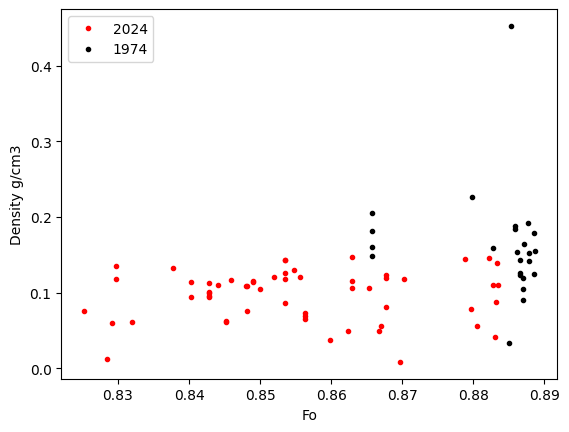

In [23]:
## Find K24 ones
K24=combined_df['filename'].str.contains('K24')
U919=combined_df['filename'].str.contains('919')

plt.plot(combined_df['Fo'].loc[K24], combined_df['Density g/cm3'].loc[K24], '.r', label='2024')

plt.plot(combined_df['Fo'].loc[U919], combined_df['Density g/cm3'].loc[U919], '.k', label='1974')

plt.legend()

plt.ylabel('Density g/cm3')

plt.xlabel('Fo')

In [24]:
# do MinML classification - assign cation totals and split into separate sheets in output excel.
def minClass(df, oxygen_num = 1):
    # prep dataframe for MinML analysis
    df['Mineral']='Olivine'
    df['entity_id']=df.index
    df_pred_nn, probability_matrix = mm.predict_class_prob_nn(df)

    # Extract key columns into main results dataframe
    # df['Predict_Mineral'] = df_pred_nn['Predict_Mineral']
    # df['Predict_Probabilty'] = df_pred_nn['Predict_Probability']
    columns = df.columns.tolist()
    if 'Predict_Mineral' in columns:
        columns.remove('Predict_Mineral')
    if 'Predict_Probability' in columns:
        columns.remove('Predict_Probability')
    columns.insert(1, 'Predict_Mineral')
    columns.insert(2, 'Predict_Probability')

    df = df.reindex(columns = columns)

    # Oxygen_numbers = {'Amphibole': 22, 'Apatite': 4, 'Biotite': 10, 'Clinopyroxene': 6,
    #                   'Garnet': 12, 'Ilmenite': 3, 'K-Feldspar': 8, 'Magnetite': 4,
    #                   'Muscovite': 10, 'Olivine': 4, 'Orthopyroxene': 6, 'Plagioclase': 8,
    #                   'Quartz': 2, 'Rutile': 2, 'Spinel': 4, 'Tourmaline': 27, 'Zircon': 4}

    # for i in df['Predict_Mineral'].unique():
    #     df.loc[df['Predict_Mineral'] == i, 'Cation_Sum'] = Oxygen_numbers[i]*df.loc[df['Predict_Mineral'] == i, 'Cation_Sum'].astype(float)/oxygen_num

    return df

    

In [25]:


# df_load = mm.load_df('RapidResponse2024/sorted_df.xlsx') 
# df_nn= mm.prep_df_nn(df_load)
# final_df = minClass(df_nn)
sorted_df.to_excel('Results.xlsx')
# final_df

In [26]:
final_df_reset = final_df.reset_index()
merged_df = pd.merge(final_df_reset, sorted_df, on = 'SampleID', how = 'inner')
merged_df.set_index('SampleID', inplace = True)
merged_df

NameError: name 'final_df' is not defined

In [ ]:
sorted_df['Fo'] = 100*(sorted_df['MgO']/40.3044)/(sorted_df['MgO']/40.3044 + sorted_df['FeOt']/71.844)

(array([ 5.,  1.,  6.,  6., 13.,  4.,  3.,  7.,  0.,  5.]),
 array([82.78973779, 83.34656571, 83.90339363, 84.46022154, 85.01704946,
        85.57387737, 86.13070529, 86.6875332 , 87.24436112, 87.80118904,
        88.35801695]),
 <BarContainer object of 10 artists>)

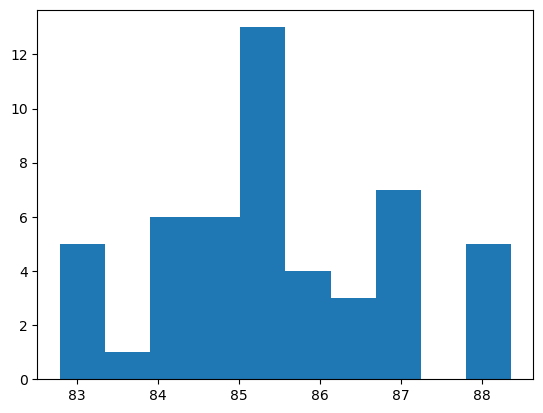

In [ ]:
f, a = plt.subplots(1,1)
a.hist(sorted_df['Fo'].loc[13:])

In [ ]:
sorted_df.loc[0:15]

,Sample Name,Total_wt%,Total_Oxide%,Al2O3,CaO,Cr2O3,Cu,FeOt,MgO,MnO,...,Line_Ca,Line_Mn,Line_Fe,Line_Ni,Line_Al,Line_Ti,Line_Cr,Line_Cu,SampleID,Fo
0,SanCarlos1_1,99.0946,99.0946,NaN,0.1485,NaN,NaN,9.5936,48.5079,0.0882,...,K series,K series,K series,Kα,NaN,NaN,NaN,NaN,SanCarlos1_1,90.012974
1,SanCarlos1_2,99.5029,99.5029,NaN,0.0363,NaN,NaN,9.8525,48.5695,0.1194,...,K series,K series,K series,Kα,NaN,NaN,NaN,NaN,SanCarlos1_2,89.782673
2,SanCarlos1_3,99.8710,99.8710,NaN,0.1326,NaN,NaN,9.6518,48.5980,0.2015,...,K series,K series,K series,Kα,NaN,NaN,NaN,NaN,SanCarlos1_3,89.975221
3,SanCarlos1_4,99.0721,99.0721,NaN,-0.0207,NaN,NaN,9.5304,48.3042,0.1860,...,K series,K series,K series,Kα,NaN,NaN,NaN,NaN,SanCarlos1_4,90.034540
4,Springwater1_1,100.5117,100.5117,NaN,0.0380,NaN,NaN,16.5200,43.7118,0.3233,...,K series,K series,K series,Kα,NaN,NaN,NaN,NaN,Springwater1_1,82.507006
5,Springwater1_2,99.1100,99.1100,NaN,0.0042,NaN,NaN,17.0157,43.0046,0.2564,...,K series,K series,K series,Kα,NaN,NaN,NaN,NaN,Springwater1_2,81.834981
6,Springwater1_3,98.1049,98.1049,NaN,-0.0561,NaN,NaN,16.5103,42.4032,0.3740,...,K series,K series,K series,Kα,NaN,NaN,NaN,NaN,Springwater1_3,82.072628
7,Jhyp1_1,99.9566,99.9566,0.9955,1.3316,0.6310,NaN,15.0677,26.2158,0.4920,...,K series,K series,K series,K series,K series,K series,K series,NaN,Jhyp1_1,75.617929
8,Jhyp1_2,100.0610,100.0610,0.9956,1.2352,0.6554,NaN,14.9359,26.5215,0.5122,...,K series,K series,K series,K series,K series,K series,K series,NaN,Jhyp1_2,75.991699
9,Jhyp1_3,100.2552,100.2552,1.0223,1.3738,0.7290,NaN,14.8907,26.7172,0.5923,...,K series,K series,K series,K series,K series,NaN,K series,NaN,Jhyp1_3,76.180613
